In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline


In [2]:
from os.path import expanduser
home = expanduser('~')
gc_dir = home + "/Dropbox/GalacticCenter/"

In [3]:
# extract the lightcurve data points
lc_data = numpy.genfromtxt(gc_dir+"/log/lightCurves/SgrA_lightCurve_both_4tels_all_E5_annual_points.txt")

MJD_array = numpy.array(lc_data[:,0], dtype=numpy.float64)
flux_obs_array = numpy.array(lc_data[:,1], dtype=numpy.float64)
flux_err_array = numpy.array(lc_data[:,2], dtype=numpy.float64)
livetime_array = numpy.array(lc_data[:,3], dtype=numpy.float64)

#log = list(map(lambda l: numpy.log10(l), _array))


In [4]:

total_livetime = numpy.sum(livetime_array)
fluxtime_array = flux_obs_array * livetime_array
mean_flux = numpy.sum(fluxtime_array) / total_livetime
print(mean_flux)
flux_obs_array[ flux_obs_array==0 ] = numpy.nan
flux_err_array[ flux_err_array==0 ] = numpy.nan
fluxtime_array[ fluxtime_array==0 ] = numpy.nan


2.4879835225e-09


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


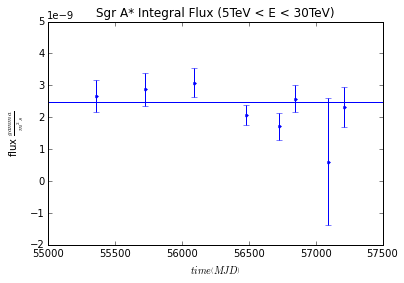

In [9]:
pyplot.errorbar(MJD_array, flux_obs_array, yerr=flux_err_array, fmt='b.') # 
pyplot.title("Sgr A* Integral Flux (5TeV < E < 30TeV)")
pyplot.xlabel(r"$time\left(MJD\right)$")
pyplot.ylabel(r"flux $\frac{gamma}{m^{2}s}$") # gamma / m^2*s*TeV
#pyplot.xlim(1.5e0, 5.e1)
pyplot.ylim(-2.e-9, 5e-9)
pyplot.axhline(mean_flux)
